In [1]:
from pathlib import Path
import pandas as pd

DATA_PATH = Path("..") / "data" / "processed" / "house_prices_clean.csv"
df = pd.read_csv(DATA_PATH)

df.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Unknown,Reg,Lvl,AllPub,Inside,...,0,Unknown,Unknown,Unknown,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Unknown,Reg,Lvl,AllPub,FR2,...,0,Unknown,Unknown,Unknown,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,Unknown,IR1,Lvl,AllPub,Inside,...,0,Unknown,Unknown,Unknown,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,Unknown,IR1,Lvl,AllPub,Corner,...,0,Unknown,Unknown,Unknown,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,Unknown,IR1,Lvl,AllPub,FR2,...,0,Unknown,Unknown,Unknown,0,12,2008,WD,Normal,250000


In [2]:
X = df.drop(columns=["SalePrice"])
y = df["SalePrice"]


In [3]:
import numpy as np

y_log = np.log1p(y)


In [4]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

len(numeric_features), len(categorical_features)


(36, 43)

In [5]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

len(numeric_features), len(categorical_features)


(36, 43)

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

linreg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

rmse


np.float64(0.1417625417201924)

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

rmse_rf


np.float64(0.14515397414084222)

In [10]:
from xgboost import XGBRegressor

xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

rmse_xgb


np.float64(0.13201807056867004)

In [11]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "RMSE": [rmse, rmse_rf, rmse_xgb]
})

results.sort_values("RMSE")


,Model,RMSE
2,XGBoost,0.132018
0,Linear Regression,0.141763
1,Random Forest,0.145154


c:\Users\boche\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


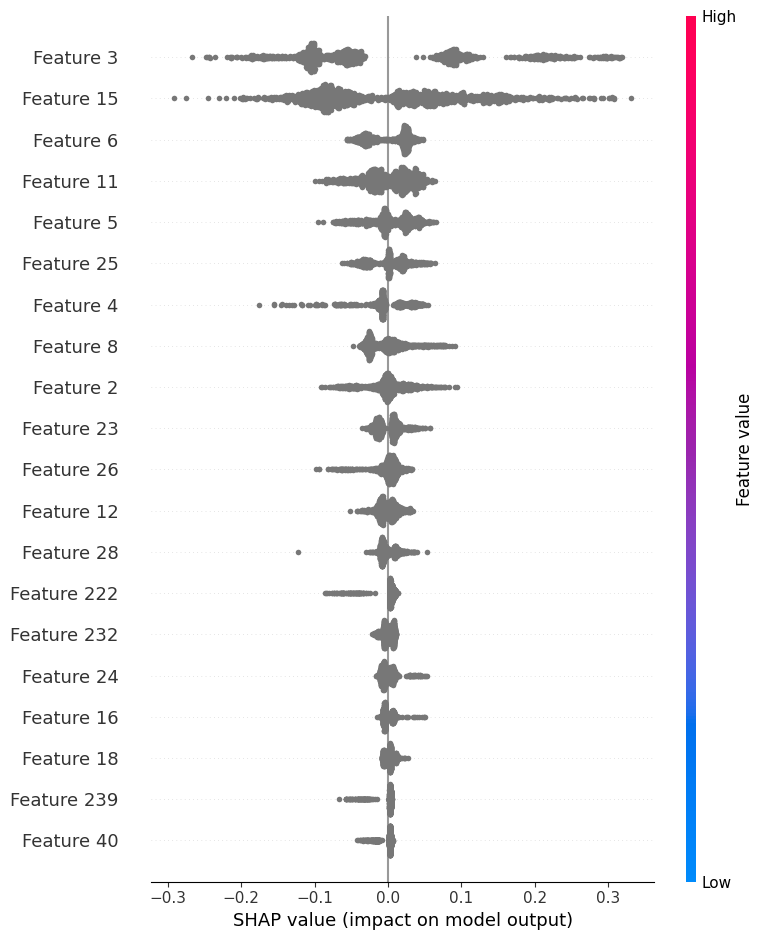

In [12]:
import shap

xgb_model = xgb.named_steps["model"]

X_train_transformed = preprocessor.fit_transform(X_train)

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed)


In [13]:
%pip install joblib

from pathlib import Path
import joblib

BASE_DIR = Path("..").resolve()

MODEL_PATH = BASE_DIR / "data" / "processed" / "xgb_pipeline.joblib"

model = joblib.load(MODEL_PATH)

print(f"Model wczytany z: {MODEL_PATH}")


Note: you may need to restart the kernel to use updated packages.
Model wczytany z: C:\Users\boche\Desktop\ds+de\data\processed\xgb_pipeline.joblib



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import joblib
from pathlib import Path


BASE_DIR = Path().resolve().parent  

MODEL_PATH = BASE_DIR / "data" / "processed" / "xgb_pipeline.joblib"

MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)

joblib.dump(xgb, MODEL_PATH)

print(f"Model zapisany w: {MODEL_PATH}")


Model zapisany w: C:\Users\boche\Desktop\ds+de\data\processed\xgb_pipeline.joblib


In [15]:
import sklearn
print(sklearn.__version__)


1.7.1


In [16]:
import sklearn
import pandas
import numpy
import xgboost
import joblib

print("sklearn:", sklearn.__version__)
print("pandas:", pandas.__version__)
print("numpy:", numpy.__version__)
print("xgboost:", xgboost.__version__)
print("joblib:", joblib.__version__)


sklearn: 1.7.1
pandas: 2.2.3
numpy: 2.2.3
xgboost: 3.0.5
joblib: 1.5.1
